# Purpose
This notebook has three goals.

First: to recreate the authors' MNL model using PyTorch.
This will give me the ability to easily extend their model as I please.

Second: to augment the author's MNL model with a neural network that implements a piecewise linear spline for `trans_access`, the sole continuous variable in the model. My intuition is that a piecewise linear specification (with structural constraints on the parameter signs to avoid illogical elasticities) will be an improvement over the MNL.

Third: To augment the model described above with a Random Forest to capture the effect of discrete variables, beyond that of the main-effects that the author's have already included in their specification.

In [1]:
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import pandas as pd

import pylogit as pl

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

# Use the following for optimization
from scipy.optimize import minimize

# PyTorch is used for general numeric computation
# with automatic differentiation
import torch
# Used to access various pytorch utilities
import torch.nn as nn
# Used to get sparse matrices =)
import torch.sparse

# Used to build the random forest addition to the choice model
from sklearn.ensemble import RandomForestRegressor

# Recreate the original MNL model using PyLogit

In [2]:
# Load the data
train_df_all =\
    pd.read_csv('./data/mnl_training_data_long_all_sample.csv')


In [3]:
# Create needed columns
for df in [train_df_all]:
    df['num_adults_eq_2'] = (df['num_adults'] == 2).astype(int)
    df['num_adults_gte_3'] = (df['num_adults'] >= 3).astype(int)
    df['sectr_1'] = (df['sectr'] == 1).astype(int)
    df['sectr_2'] = (df['sectr'] == 2).astype(int)
    df['income_1'] = (df['incom'] == 1).astype(int)
    df['income_2'] = (df['incom'] == 2).astype(int)
    df['income_4'] = (df['incom'] == 4).astype(int)
    df['income_5'] = (df['incom'] == 5).astype(int)
    df['income_gt_5'] = (df['incom'] > 5).astype(int)


In [4]:
# Create labels for the various alternatives
choice_labels =\
    {1: '0 Cars',
     2: '1 Car',
     3: '2 Cars',
     4: '3+ Cars',
    }

# Create the specification dictionaries
spec_dict, name_dict = OrderedDict(), OrderedDict()

spec_dict['intercept'] = [2, 3, 4]
spec_dict['num_adults_eq_2'] = [1, 2, 4]
spec_dict['num_adults_gte_3'] = [1, 2, 3]
spec_dict['sectr_1'] = [2, 3, 4]
spec_dict['sectr_2'] = [2, 3, 4]
spec_dict['income_1'] = [2, 3, 4]
spec_dict['income_2'] = [2, 3, 4]
spec_dict['income_4'] = [2, 3, 4]
spec_dict['income_5'] = [2, 3, 4]
spec_dict['income_gt_5'] = [2, 3, 4]
spec_dict['tran_access'] = [2, 3, 4]
spec_dict['numWorkers'] = [2, 3, 4]

for col in spec_dict:
    name_dict[col] =\
        [col + ' ({})'.format(choice_labels[x]) for x in spec_dict[col]]


In [5]:
# Take note of important data columns
ALT_ID_COL = 'altid'
CHOICE_COL = 'choiceBoolean'
OBS_ID_COL = 'sampn'

# Create the model object
mnl_model =\
    pl.create_choice_model(train_df_all,
                           ALT_ID_COL,
                           OBS_ID_COL,
                           CHOICE_COL,
                           spec_dict,
                           'MNL',
                           names=name_dict,
                          )


/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [6]:
# Fit the model
num_params_mnl = mnl_model.design.shape[1]
init_values = np.zeros(num_params_mnl)

mnl_model.fit_mle(init_values)

# Show model estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -14,528.3649
Initial Log-likelihood: -14,528.3649


/Users/tbrathwaite/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.56 seconds.
Final log-likelihood: -8,419.3714


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:               choiceBoolean   No. Observations:               10,480
Model:             Multinomial Logit Model   Df Residuals:                   10,444
Method:                                MLE   Df Model:                           36
Date:                     Mon, 13 Jan 2020   Pseudo R-squ.:                   0.420
Time:                             06:47:36   Pseudo R-bar-squ.:               0.418
AIC:                            16,910.743   Log-Likelihood:             -8,419.371
BIC:                            17,172.003   LL-Null:                   -14,528.365
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept (1 Car)             2.6264      0.255     10.311      0.000       2.127       3.126
intercept (2 Cars)            1.0124      0.469      2.159      0.031       0.093       1.931
intercept (3+ Cars)          -1.9606      1.221     -1.606      0.108      -4.353       0.432
num_adults_eq_2 (0 Cars)     -3.4084      0.331    -10.288      0.000      -4.058      -2.759
num_adults_eq_2 (1 Car)      -3.0713      0.327     -9.400      0.000      -3.712      -2.431
num_adults_eq_2 (3+ Cars)    -1.8843      1.065     -1.769      0.077      -3.973       0.204
num_adults_gte_3 (0 Cars)    -3.8212      1.022     -3.740      0.000      -5.824      -1.819
num_adults_gte_3 (1 Car)     -3.6161      1.019     -3.549      0.000      -5.613      -1.619
num_adults_gte_3 (2 Cars)    -0.5120      1.063     -0.482      0.630      -2.596       1.572
sectr_1 (1 Car)               0.5661      0.092      6.138      0.000       0.385       0.747
sectr_1 (2 Cars)              0.2848      0.156      1.831      0.067      -0.020       0.590
sectr_1 (3+ Cars)             0.6836      0.305      2.239      0.025       0.085       1.282
sectr_2 (1 Car)              -1.5095      0.064    -23.608      0.000      -1.635      -1.384
sectr_2 (2 Cars)             -2.9781      0.128    -23.285      0.000      -3.229      -2.727
sectr_2 (3+ Cars)            -3.2721      0.387     -8.456      0.000      -4.031      -2.514
income_1 (1 Car)             -1.8959      0.097    -19.483      0.000      -2.087      -1.705
income_1 (2 Cars)            -3.5720      0.359     -9.959      0.000      -4.275      -2.869
income_1 (3+ Cars)           -3.5108      1.047     -3.352      0.001      -5.563      -1.458
income_2 (1 Car)             -0.9951      0.071    -14.090      0.000      -1.134      -0.857
income_2 (2 Cars)            -1.7182      0.135    -12.737      0.000      -1.983      -1.454
income_2 (3+ Cars)           -2.2863      0.439     -5.205      0.000      -3.147      -1.425
income_4 (1 Car)              0.7917      0.106      7.469      0.000       0.584       0.999
income_4 (2 Cars)             1.5112      0.123     12.328      0.000       1.271       1.751
income_4 (3+ Cars)            1.8265      0.246      7.423      0.000       1.344       2.309
income_5 (1 Car)              1.3261      0.209      6.343      0.000       0.916       1.736
income_5 (2 Cars)             3.1611      0.215     14.737      0.000       2.741       3.582
income_5 (3+ Cars)            3.8959      0.297     13.112      0.000       3.314       4.478
income_gt_5 (1 Car)          -0.2626      0.089     -2.961      0.003      -0.436      -0.089
income_gt_5 (2 Cars)          0.2713      0.118      2.295      0.022       0.040       0.503
income_gt_5 (3+ Cars)         0.7713      0.274      2.817      0.005       0.235       1.308
tran_access (1 Car)          -0.3569      0.038     -9.512      0.000      -0.430      -0.283


# Recreate the original MNL model using PyTorch

### Convert training and testing data to pytorch format

In [7]:
# Cast all arrays as 2D arrays of float32 elements
# because that's what pytorch likes
x_train = mnl_model.design.astype(np.float32)
y_train = mnl_model.choices.astype(np.float32)[:, None]

# 2.3 Convert the data from numpy arrays into pytorch variables
x_train_torch = torch.from_numpy(x_train)
y_train_torch = torch.from_numpy(y_train)

### Create needed helper functions

In [8]:
# 5.0 Make helper functions needed for model training
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_numpy_grad(model):
    return np.concatenate(list(x.grad.data.numpy().ravel()
                               for x in model.parameters()),
                          axis=0)

def get_numpy_params(model):
    return np.concatenate(list(x.data.numpy().ravel()
                               for x in model.parameters()),
                          axis=0)


def vec_to_state_dict(vec,
                      model,  
                      param_shapes=None, # keys = param names; vals = size tuple
                     ):
    # Figure out the number of parameters in the model
    total_num_params = count_parameters(model)
    if vec.shape[0] != total_num_params:
        msg = '`vec` and `model` MUST have the same number of parameters.'
        raise ValueError(msg)
    # Create a new state dict
    new_state = deepcopy(model.state_dict())
    # Pointer for slicing the vector for each parameter
    pointer = 0
    for pos, param in enumerate(model.parameters()):
        # The length of the parameter
        num_param = param.numel()
        # Get the name of the current parameter
        param_name = list(new_state.keys())[pos]
        # Slice the vector, reshape it, and replace the old values
        if num_param == 1:
            new_state[param_name] =\
                vec[pointer:pointer + num_param].double()
        else:
            if param_shapes is not None:
                shape_tuple = param_shapes[param_name]
            else:
                shape_tuple = (1, -1)
            new_state[param_name] =\
                vec[pointer:pointer + num_param].view(*shape_tuple).double()
        # Increment the pointer
        pointer += num_param
    return new_state


def set_model_params(params,
                     model,
                     param_shapes=None, # keys = param names vals = size tuple
                    ):
    # Convert the numpy array torch a pytorch tensor
    if isinstance(params, np.ndarray):
        param_tensor =\
            (torch.tensor(params,
                          requires_grad=True)
                  .double())
    else:
        param_tensor = params
    # Conver the vector into a pytorch state dict
    current_state_dict =\
        vec_to_state_dict(param_tensor, model, param_shapes=param_shapes)
    # Load the new state dict onto the model
    model.load_state_dict(current_state_dict)
    return None
        

def make_scipy_closure(
        design,
        targets,
        model,
        loss_func,
        param_shapes=None, # keys = param names vals = size tuple
        ):
    def closure(params):
        # params -> loss, grad
        # Load the parameters onto the model
        set_model_params(params, model, param_shapes=param_shapes)
        # Ensure the gradients are summed starting from zero
        model.zero_grad()
        # Calculate the loss
        loss =\
            loss_func(model(design), targets)
        # Compute the gradients
        loss.backward()
        # Get the gradient.
        grad = get_numpy_grad(model)
        # Get a value of the loss to pass around?
        loss_val = loss.detach().numpy()
        return loss_val, grad
    return closure



## Make the PyTorch MNL class using mapping matrices

In [9]:
# 3. Set up the model in pytorch again
num_beta_params = x_train_torch.shape[1]
num_alts = 3

class MNL_Torch_v2(nn.Module):
    """
    Uses sparse matrices
    """
    def __init__(self,
                 num_index_params,
                 num_alternatives,
                 rows_to_obs, # torch.sparse.FloatTensor
                 min_exponent_val=-700,
                 max_exponent_val=700,
                 max_comp_value=1e300,
                 max_sub_1=1-1e16,
                 min_comp_value=1e-300):
        super(MNL_Torch_v2, self).__init__()
        # Store needed constants for the model
        self.num_alternatives = int(num_alternatives)
        self.num_index_params = int(num_index_params)
        self.rows_to_obs = rows_to_obs
        
        # Store constants related to avoiding numerical overflow or underflow
        self.min_exponent_val = min_exponent_val
        self.max_exponent_val = max_exponent_val
        self.min_comp_value = min_comp_value
        self.max_sub_1 = max_sub_1
        self.max_comp_value = max_comp_value

        # Store computation layers as attributes
        self.linear =\
            nn.Linear(num_index_params, 1, bias=False)
        return None

    def forward(self, inputs):
        # Note we use clamp to guard against later over- or under-flow.
        sys_utilities =\
            torch.clamp(self.calc_sys_utilities(inputs),
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)

        exponentiated_sys_utilities = torch.exp(sys_utilities)

        # Get the denominators for calculating the probabilities
        # There will be one entry per observation
        denominators_by_obs =\
            torch.sparse.mm(self.rows_to_obs.transpose(0, 1),
                            exponentiated_sys_utilities)
        # Convert the denominators into an array of length sys_utilities.size[0]
        long_denominators = torch.sparse.mm(self.rows_to_obs, denominators_by_obs)

        # Note we use clamp to guard against against zero probabilities.
        long_probs =\
            torch.clamp(exponentiated_sys_utilities / long_denominators,
                        min=self.min_comp_value,
                        max=1.0)
        return long_probs
    
    def calc_sys_utilities(self, inputs):
        return self.linear(inputs)

    def convert_long_to_wide(self, input_1d):
        orig_num_rows = input_1d.size()[0]
        new_num_rows =\
            int(orig_num_rows / self.num_alternatives)
        wide_tensor = input_1d.view(new_num_rows, self.num_alternatives)
        return wide_tensor

    def convert_wide_to_long(self, input_2d):
        orig_num_rows = input_2d.size()[0]
        new_num_rows =\
            int(orig_num_rows) * self.num_alternatives
        long_tensor = input_2d.view(new_num_rows, 1)
        return long_tensor

    def safe_logistic(self, inputs):
        safe_input =\
            torch.clamp(inputs,
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)
        return torch.pow(1 + torch.exp(-1 * safe_input), -1)
    
    def safe_logit(self, inputs):
        safe_input =\
            torch.clamp(inputs, min=self.min_comp_value, max=self.max_sub_1)
        return torch.log(safe_input / (1 - safe_input))

In [10]:
####
# Create the mapping matrices for pytorch
####
# Get the needed mapping matrix from pylogit, in the format used by pytorch
row_to_obs_mnl_coo =\
    mnl_model.get_mappings_for_fit()['rows_to_obs'].tocoo()

# Extract the sparsity structure information from the scipy.sparse matrix
# for passing to pytorch
concatenated_row_to_obs_iv_info =\
    torch.from_numpy(
        np.concatenate((row_to_obs_mnl_coo.row[None, :],
                        row_to_obs_mnl_coo.col[None, :]),
                       axis=0)
    ).long()

# Get the non-zero values from the mapping matrix
row_to_obs_mnl_data_torch =\
    torch.from_numpy(row_to_obs_mnl_coo.data.astype(np.float32)).double()

# Create the mapping matrix in pytorch
rows_to_obs_torch =\
    torch.sparse.FloatTensor(
      concatenated_row_to_obs_iv_info,
      row_to_obs_mnl_data_torch
    ).double()

# Initialize the pytorch MNL model
torch_mnl_2 = MNL_Torch_v2(num_beta_params,
                           num_alts,
                           rows_to_obs_torch).double()

In [11]:
%pdb on
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in torch_mnl_2.state_dict():
    print(param_tensor, "\t", torch_mnl_2.state_dict()[param_tensor].size())

# Check that the pytorch MNL implementation works
# Set the model parameters from the estimated pylogit params
set_model_params(mnl_model.params.values, torch_mnl_2)

# Compute probabilities
x_train_torch = x_train_torch.double()
torch_long_probs_2 = torch_mnl_2.forward(x_train_torch)
# Get the probabilities as a numpy array
numpy_long_probs_from_torch_2 = torch_long_probs_2.detach().numpy().ravel()
# Make sure the probabilities are all close-ish
np.allclose(numpy_long_probs_from_torch_2, mnl_model.long_fitted_probs)

# Chcek that the log-likelihoods are equal-ish
torch_log_like_2 = np.dot(mnl_model.choices,
                        np.log(numpy_long_probs_from_torch_2.ravel()))
print("Log-Likelihood values")
print(torch_log_like_2, mnl_model.llf)

Automatic pdb calling has been turned ON
Model's state_dict:
('linear.weight', '\t', torch.Size([1, 36]))
Log-Likelihood values
(-8419.371342840095, -8419.371351263893)


## Woohoo I can use sparse matrices to recreate the pylogit mnl! 

## Add a hidden layer to the MNL model
- Note this hidden layer contain three "neurons," each being a piecewise linear spline.
- There will be one neuron per alternative for owning more than zero cars.
- This will implement a different piecewise linear spline per utility function.

In [12]:
class HiddenLayerMNL(MNL_Torch_v2):
    def __init__(self,
                 num_index_params,
                 num_alternatives,
                 rows_to_obs, # torch.sparse.FloatTensor
                 num_hidden_units_per_spline=10,
                 min_exponent_val=-700,
                 max_exponent_val=700,
                 max_comp_value=1e300,
                 max_sub_1=1-1e16,
                 min_comp_value=1e-300):
        super(HiddenLayerMNL, self).__init__(
            num_index_params,
            num_alternatives,
            rows_to_obs,
            min_exponent_val=min_exponent_val,
            max_exponent_val=max_exponent_val,
            max_comp_value=max_comp_value,
            max_sub_1=max_sub_1,
            min_comp_value=min_comp_value
        )
        # Store needed constants for the model
        self.num_hidden_units_per_spline = int(num_hidden_units_per_spline)
        
        # Organize info on the splines
        self.spline_column_list = [-6, -5, -4]
        self.num_splines = len(self.spline_column_list)

        # Create parameters for the splines
        self.spline_linear_coef_params =\
            torch.nn.Parameter(
                torch.zeros(
                    torch.Size([self.num_splines,
                                num_hidden_units_per_spline]
                                ),
                    dtype=torch.double,
                    requires_grad=True))

        self.spline_knot_params =\
            torch.nn.Parameter(
                torch.zeros(
                    torch.Size([self.num_splines,
                                num_hidden_units_per_spline]),
                    dtype=torch.double,
                    requires_grad=True))

        # Combine all spline info
        self.spline_info =\
            [(self.spline_linear_coef_params[x, :],
              self.spline_knot_params[x, :],
              self.spline_column_list[x]) for x in range(self.num_splines)]

        # Create a ReLU layer
        self.relu = nn.ReLU()

        # Store computation layers as attributes
        self.linear =\
            nn.Linear(self.num_index_params, 1, bias=False)
        return None
    
    def calc_sys_utilities(self, inputs):
        # Calculate X * beta
        linear_term = self.linear(inputs)
        
        # Initialize the systematic utility values to be returned
        sys_utility_vals = linear_term
            
        # Calculate the addition to the systematic utilities per spline
        for pos, info in enumerate(self.spline_info):
            # Unpack the info needed from the splines
            spline_linear_coefs, spline_knot_params, col = info
            
            # Compute -1 * exp(spline_linear_coef_param)
            # This ensures the derivative with respect to the transit
            # access variable will be negative for the given alternatives
            # that have 1, 2, or 3+ cars relative to zero cars
            current_transformed_spline_linear_coefs =\
                -1 * torch.exp(torch.clamp(spline_linear_coefs,
                                           min=self.min_exponent_val,
                                           max=self.max_exponent_val))

            # Compute max(0, [x - knot])
            current_pre_spline_vals =\
                self.relu(inputs[:, col][:, None] - spline_knot_params[None, :])

            # Compute 
            # sum_{hidden_units} {-1 * exp(spline_linear_coef_param) *
            #                     max(0, [x - knot])}
            current_spline_vals =\
                torch.mm(current_pre_spline_vals,
                         current_transformed_spline_linear_coefs[:, None])
                
            # Increment the systematic utility values
            sys_utility_vals = sys_utility_vals + current_spline_vals
        return sys_utility_vals
    
    def forward(self, inputs):
        # Note we use clamp to guard against later over- or under-flow.
        sys_utilities =\
            torch.clamp(self.calc_sys_utilities(inputs),
                        min=self.min_exponent_val,
                        max=self.max_exponent_val)

        exponentiated_sys_utilities = torch.exp(sys_utilities)

        # Get the denominators for calculating the probabilities
        # There will be one entry per observation
        denominators_by_obs =\
            torch.sparse.mm(self.rows_to_obs.transpose(0, 1),
                            exponentiated_sys_utilities)
        # Convert the denominators into an array of length sys_utilities.size[0]
        long_denominators =\
            torch.sparse.mm(self.rows_to_obs, denominators_by_obs)

        # Note we use clamp to guard against against zero probabilities.
        long_probs =\
            torch.clamp(exponentiated_sys_utilities / long_denominators,
                        min=self.min_comp_value,
                        max=1.0)
        return long_probs
            

## Check that the new model is initialized at the MNL log likelihood

In [13]:
# Determine how many units per spline
NUM_KNOTS = 10
# Initialize the new model
new_model = HiddenLayerMNL(num_beta_params,
                           num_alts,
                           rows_to_obs_torch,
                           num_hidden_units_per_spline=NUM_KNOTS)

####
# Set the initial parameters
####
# Note the shapes of the parameters
param_shape_dict_new_model =\
    {'spline_linear_coef_params': (3, NUM_KNOTS),
     'spline_knot_params': (3, NUM_KNOTS),
     'linear.weight': (1, 36)}

# Create initial knot values
initial_knot_vals =\
    (pd.Series(train_df_all['tran_access'].values
                   [np.nonzero(train_df_all['tran_access'].values)])
       .describe(percentiles=[0.05 + 0.1 * x
                              for x in range(NUM_KNOTS)])).values[-11:-1]

# Note the initial parameter values as a correctly ordered state dict
initial_vals_new_model = OrderedDict()
initial_vals_new_model['spline_linear_coef_params'] =\
     (torch.from_numpy(
          np.ones((3, NUM_KNOTS)) * -5
#           np.log(np.abs(mnl_model.params.values[[-6, -5, -4]][:, None]))
                      )
           .double())

initial_vals_new_model['spline_knot_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * initial_knot_vals[None, :])
           .double()
     )

initial_vals_new_model['linear.weight'] =\
    torch.from_numpy(mnl_model.params.values[None, :]).double()

# Note the initial parameter values as a correctly ordered numpy
# array we can use to set the parameters with
initial_vals_new_model_numpy =\
    np.concatenate(
        tuple(t.data.numpy().ravel() for t in initial_vals_new_model.values()),
        axis=0)

# Set the model parameters
set_model_params(initial_vals_new_model_numpy,
                 new_model,
                 param_shapes=param_shape_dict_new_model)
new_model.double()

# Look at the current params
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", new_model.state_dict()[param_tensor])
    print('\n')

Model's state_dict:
('spline_linear_coef_params', '\t', torch.Size([3, 10]))
('spline_linear_coef_params', '\t', tensor([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
        [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
        [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.]],
       dtype=torch.float64))


('spline_knot_params', '\t', torch.Size([3, 10]))
('spline_knot_params', '\t', tensor([[5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814],
        [5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814],
        [5.0360, 5.3479, 5.5561, 6.0149, 6.0958, 6.2924, 6.5286, 6.6412, 6.8725,
         7.1814]], dtype=torch.float64))


('linear.weight', '\t', torch.Size([1, 36]))
('linear.weight', '\t', tensor([[ 2.6264,  1.0124, -1.9606, -3.4084, -3.0713, -1.8843, -3.8212, -3.6161,
         -0.5120,  0.5661,  0.2848,  0.6836, -1.5095, -2.9781, -3.2721, -1.8959,
         -3.5720, -3.5108, -0.9951, -1.7182

In [14]:
####
# Check initial probabilities with new model
####

# Compute probabilities
x_train_torch = x_train_torch.double()
torch_long_probs_new = new_model.forward(x_train_torch)
# Get the probabilities as a numpy array
numpy_long_probs_from_torch_new = torch_long_probs_new.data.numpy().ravel()
# Make sure the probabilities are all close-ish
print("Probs all close?",
      np.allclose(numpy_long_probs_from_torch_new, mnl_model.long_fitted_probs))

# Chcek that the log-likelihoods are equal-ish
torch_log_like_new = np.dot(mnl_model.choices,
                        np.log(numpy_long_probs_from_torch_new.ravel()))
print("Log-Likelihood values")
print(torch_log_like_new, mnl_model.llf)

('Probs all close?', False)
Log-Likelihood values
(-8419.280009275899, -8419.371351263893)


## Estimate the new model

### Create a loss for the model

In [15]:
class NegLogLikelihood(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        
    def forward(self, probs, targets):
        total_loss =\
            (-1 * torch.dot(torch.flatten(targets),
                            torch.log(torch.flatten(probs))))
        return total_loss


In [16]:
# Set up a loss for pytorch training
pytorch_loss = NegLogLikelihood()

# Determine how many units per spline
NUM_KNOTS = 10

# Initialize the new model
new_model = HiddenLayerMNL(num_beta_params,
                           num_alts,
                           rows_to_obs_torch,
                           num_hidden_units_per_spline=NUM_KNOTS)

####
# Set the initial parameters
####
# Note the shapes of the parameters
param_shape_dict_new_model =\
    {'spline_linear_coef_params': (3, NUM_KNOTS),
     'spline_knot_params': (3, NUM_KNOTS),
     'linear.weight': (1, 36)}

# Create initial knot values that are the percentiels of the transit access variable
initial_knot_vals =\
    (pd.Series(train_df_all['tran_access'].values
                   [np.nonzero(train_df_all['tran_access'].values)])
       .describe(percentiles=[0.05 + 0.1 * x
                              for x in range(NUM_KNOTS)])).values[-11:-1]

# Note the initial parameter values as a correctly ordered state dict
initial_vals_new_model = OrderedDict()

# Start the spline coefficients near zero to be close to the MNL
initial_vals_new_model['spline_linear_coef_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * -5
                      )
           .double())

initial_vals_new_model['spline_knot_params'] =\
     (torch.from_numpy(
         np.ones((3, NUM_KNOTS)) * initial_knot_vals[None, :])
           .double()
     )

initial_vals_new_model['linear.weight'] =\
    torch.from_numpy(mnl_model.params.values[None, :]).double()

# Note the initial parameter values as a correctly ordered numpy
# array we can use to set the parameters with
initial_vals_new_model_numpy =\
    np.concatenate(
        tuple(t.data.numpy().ravel() for t in initial_vals_new_model.values()),
        axis=0)

# Set the initial model parameters
set_model_params(initial_vals_new_model_numpy,
                 new_model,
                 param_shapes=param_shape_dict_new_model)
new_model.double()

# Make sure the input and model has the correct type
x_train_torch = x_train_torch.double()
y_train_torch = y_train_torch.double()

####
# Create numpy compatible loss and gradient
####
# Create the closure for the model
scipy_loss_and_grad =\
    make_scipy_closure(
        x_train_torch,
        y_train_torch,
        new_model,
        pytorch_loss,
        param_shapes=param_shape_dict_new_model)

# Look at the initial loss value
initial_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
print("Initial loss value: {:,.5f}".format(initial_loss_val.data))

Initial loss value: 8,419.28001


### Perform the minimization

In [17]:
# Perform the minimization
results =\
    minimize(
        scipy_loss_and_grad, initial_vals_new_model_numpy, method='l-bfgs-b', jac=True)
print(results['message'])

# Look at the current loss value
current_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
print("Final loss value: {:,.5f}".format(current_loss_val.data))

# Look at the current gradient and its norm to assess convergence.
grad = get_numpy_grad(new_model)
grad_norm = np.linalg.norm(grad)
print("Gradient: \n{}".format(grad))
print("Gradient norm: {:,.6f}".format(grad_norm))

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Final loss value: 8,406.65938
Gradient: 
[ 2.58630451e-03 -3.96025773e-03 -7.98353566e-02  3.62998187e-03
  5.89447511e-02  1.28600045e-01  4.00684022e-02  3.06070033e-02
  3.41771873e-03  0.00000000e+00 -6.02721186e-02  1.12701641e-03
 -2.20122802e-03 -1.36466783e-01 -1.48651344e-01 -1.96691398e-01
 -1.38994076e-01 -1.45014883e-01 -5.54919714e-02 -1.10505520e-04
  3.12116529e-02  8.58672871e-02  2.01121141e-01  2.00103697e-01
  1.59783605e-01  9.35705118e-02  5.23335787e-02  3.18080366e-02
  1.12294035e-02  1.10633133e-04 -7.03945489e-02 -3.44335838e-01
  8.85769888e-02 -5.44912445e-01  3.32674590e-02 -5.63685186e-01
 -2.66543890e-03  2.03333017e-01 -2.87217193e-02  0.00000000e+00
  6.07504044e-02 -5.71956667e-03 -8.44409509e-02  3.93913150e-01
 -3.36398490e-01 -4.51719602e+00 -3.14267533e-01  4.18182111e-01
  6.06023938e-02  9.49292087e-04 -2.90185355e-02 -8.31567857e-02
  1.62975558e-01 -4.86611441e-02 -3.65618709e-01 -6.13545256e-03
 

### Look at the estimated parameters

In [18]:
# Look at the current params
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", new_model.state_dict()[param_tensor])
    print('\n')

Model's state_dict:
('spline_linear_coef_params', '\t', torch.Size([3, 10]))
('spline_linear_coef_params', '\t', tensor([[-3.5409, -2.1945, -2.5927, -1.9343, -2.1892, -1.2520, -2.4435, -3.0483,
         -4.9526, -4.9936],
        [-4.0424, -4.8904, -4.5543, -2.4991, -2.4132, -0.4969, -2.4812, -2.4393,
         -3.3195, -4.9148],
        [-3.2000, -2.1590, -1.2807, -1.1506, -1.3950, -2.0534, -2.6010, -3.1493,
         -4.3098, -4.8112]], dtype=torch.float64))


('spline_knot_params', '\t', torch.Size([3, 10]))
('spline_knot_params', '\t', tensor([[6.2153, 6.2477, 5.1378, 6.2305, 5.9017, 5.5140, 5.5036, 5.5711, 5.4914,
         7.7384],
        [5.2662, 6.4101, 6.4946, 6.0159, 6.0136, 6.5092, 6.0140, 6.0155, 6.0600,
         7.3999],
        [5.8985, 5.9290, 6.0277, 6.1424, 6.1287, 6.0660, 6.0065, 5.9319, 5.7958,
         6.4116]], dtype=torch.float64))


('linear.weight', '\t', torch.Size([1, 36]))
('linear.weight', '\t', tensor([[-0.4566, -0.7147, -4.2658, -3.4245, -3.0945, -2.1271, -3

In [19]:
# Look at the final knot positions for each alternative
final_spline_knot_params = new_model.spline_knot_params.data.numpy()

for i in [0, 1, 2]:
    print(np.sort(final_spline_knot_params[i, :]))

[5.13783575 5.49135603 5.50362383 5.51403638 5.57105688 5.90168814
 6.21531294 6.23048093 6.24767389 7.73843451]
[5.26619363 6.01358719 6.01397601 6.01552791 6.01586363 6.05996155
 6.41010307 6.4946217  6.50915594 7.39991148]
[5.79580191 5.89852388 5.92903363 5.93186106 6.00649999 6.02765559
 6.0659523  6.12872403 6.14244136 6.41156787]


Hmm, from above I see that I should probably implement a transformation such that the knot positions stay inside the range of the observed data. Otherwise the knot position could go outside the observed data and then start getting gradients of zero...

### Look at the gradient of the estimated parameters

In [20]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    return None
    

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    return None

Loss value: 8,406.65938


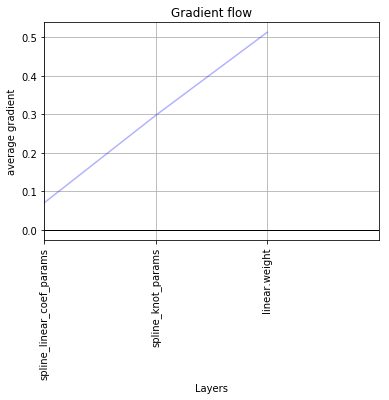

In [21]:
####
# Examine the gradients of the new model
####
# Ensure we start calculating gradients at zero
new_model.zero_grad()
# Look at the initial loss value
current_loss_val = pytorch_loss(new_model(x_train_torch), y_train_torch)
# Get gradients of the loss
current_loss_val.backward()
print("Loss value: {:,.5f}".format(current_loss_val.data))
plot_grad_flow(new_model.named_parameters())

# Recap

Okay. I'm able to estimate something. The final gradient, while not zero, isn't a horrendously huge number. The training loss has decreased, which is encouraging. And finally, the parameters have made significant moves from their starting values into reasonable terminating values.

However, the performance is still nothing like the random forest. I'm assuming this means the discrete features are carrying all the predictive power and I should make use of them?


# Add Random Forests

The basic idea is to use gradient boosting to add the random forests to the systematic utilities of the choice model.

We'll use one step of gradient boosting where the "weak learner" is a random forest. Note we use only one step to stay far from overfitting.

Also, there is one random forest per systematic utility, and these forests only use the discrete variables that are present in the linear portion of that systematic utility. This is done to avoid mother logit complaints and to avoid any issues with illogical elasticities with respect to transit access. The random forest simply will not be based on transit access at all.

In [22]:
def get_design_columns_for_rf(
    model_obj, model_spec, alt_id, choice_label_dict):
    """
    Gets all the column indices from model_obj.design that
    correspong to non-intercept and non-tran_access variables
    for a given alternative. These are the discrete variable
    columns for each alternative's systematic utilities.
    """
    # Get the model parameter names
    model_param_name_list = model_obj.params.index.values.tolist()
    # Determine the columns to pay attention to
    col_list = []
    for col_name in model_spec:
        # Skip the intercept column as its the same value for everyone
        # Skip trans_access as we just want discrete values
        if col_name in ['intercept', 'tran_access']:
            continue
        # Get the name of the associated model parameter for this column
        param_name = col_name + ' ({})'.format(choice_label_dict[alt_id])
        # Get the design matrix column corresponding to this parameter
        if param_name not in model_param_name_list:
            continue
        design_column_idx = model_param_name_list.index(param_name)
        # Store the identified column
        col_list.append(design_column_idx)
    return col_list
            

In [23]:
#Test that the function works
rf_design_cols =\
    {alt: get_design_columns_for_rf(mnl_model, spec_dict, alt, choice_labels)
     for alt in range(1, 5)}


rf_design_cols

{1: [3, 6],
 2: [4, 7, 9, 12, 15, 18, 21, 24, 27, 33],
 3: [8, 10, 13, 16, 19, 22, 25, 28, 34],
 4: [5, 11, 14, 17, 20, 23, 26, 29, 35]}

In [24]:
# Get the current residuals (aka the gradient of the log-likelihoods
# with respect to the systematic utilities)
mnl_plus_net_residuals =\
    (y_train_torch - new_model(x_train_torch)).data.numpy().ravel()

# Set a random seed for reproducibility
np.random.seed(452)

# Subsample the data based on the observation ids
forest_subsample_decimal = 0.75
train_obs_ids = np.sort(train_df_all[mnl_model.obs_id_col].unique())
num_subsamples = int(forest_subsample_decimal * train_obs_ids.size)

subsampled_ids =\
    np.random.choice(train_obs_ids, size=num_subsamples, replace=False)
subsampled_row_indicator =\
    train_df_all[mnl_model.obs_id_col].isin(subsampled_ids).values
subsampled_train_df =\
    train_df_all.loc[subsampled_row_indicator]

# Determine the columns to be used in the random forests, aka all the
# discrete variables from an alternative's systematic utilities
rf_design_cols =\
    {alt: get_design_columns_for_rf(mnl_model, spec_dict, alt, choice_labels)
     for alt in range(1, 5)}


#####
# Use the subsampled data to predict the residuals for each observation
#####
# Initialize a  dictionary to store the random forest objects after creation
alt_to_random_forest_dict = {}

# Initialize a column for the predicted residuals from the random forests
rf_prediction_col = 'pred_rf_residuals'
train_df_all[rf_prediction_col] = 0

for alt in range(1, 5):
    # Figure out what rows of the training data . correspond to this alternative
    alt_indicator_full_data = (train_df_all[mnl_model.alt_id_col] == alt).values
    # Get the subsampled training data for this alternative's random forest.
    subsampled_x_for_rf =\
        mnl_model.design[subsampled_row_indicator *
                         alt_indicator_full_data, :][:, rf_design_cols[alt]]
    subsampled_y_for_rf =\
        mnl_plus_net_residuals[subsampled_row_indicator * alt_indicator_full_data]
    # Build a random forest to predict the residuals
    random_forest = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)
    random_forest.fit(subsampled_x_for_rf, subsampled_y_for_rf)
    # Save the forest
    alt_to_random_forest_dict[alt] = random_forest
    # Make and store predictions on the complete dataset
    full_x_for_rf =\
        mnl_model.design[alt_indicator_full_data, :][:, rf_design_cols[alt]]
    train_df_all.loc[alt_indicator_full_data, rf_prediction_col] =\
        random_forest.predict(full_x_for_rf)


In [25]:
####
# Add the MNL + Net systematic utilities to the dataset
####
# Note the clamping guards against overflow and underflow
train_df_all['mnl_plus_net_systematic_utilities'] =\
    torch.clamp(new_model.calc_sys_utilities(x_train_torch),
                min=new_model.min_exponent_val,
                max=new_model.max_exponent_val).data.numpy().ravel()

In [26]:
# Build a final model based on the new random forest predictions and previous
# MNL + Neural Net predictions
final_spec_dict, final_name_dict = OrderedDict(), OrderedDict()

# Add needed predictors to the specification and name dictionaries
final_spec_dict['mnl_plus_net_systematic_utilities'] = [[1, 2, 3, 4]]
final_name_dict['mnl_plus_net_systematic_utilities'] = ['mnl_plus_net_sys_utilities']

# We exclude alternative 1 for identifiability since the residuals must sum to zero
final_spec_dict[rf_prediction_col] = [2, 3, 4]
final_name_dict[rf_prediction_col] =\
     [rf_prediction_col + ' ({})'.format(choice_labels[x]) for x in final_spec_dict[rf_prediction_col]]


In [27]:
# Create the final model object
final_mnl_model =\
    pl.create_choice_model(train_df_all,
                           ALT_ID_COL,
                           OBS_ID_COL,
                           CHOICE_COL,
                           final_spec_dict,
                           'MNL',
                           names=final_name_dict,
                          )

# Fit the model
num_params_final_mnl = final_mnl_model.design.shape[1]
init_values = np.zeros(num_params_final_mnl)
# Start off exactly matching the MNL + Net predictions
init_values[0] = 1

final_mnl_model.fit_mle(init_values, constrained_pos=[0])

# Show model estimation results
final_mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -14,528.3649
Initial Log-likelihood: -8,406.6594
Estimation Time for Point Estimation: 0.03 seconds.
Final log-likelihood: -8,365.6404


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:               choiceBoolean   No. Observations:               10,480
Model:             Multinomial Logit Model   Df Residuals:                   10,476
Method:                                MLE   Df Model:                            4
Date:                     Mon, 13 Jan 2020   Pseudo R-squ.:                   0.424
Time:                             06:48:42   Pseudo R-bar-squ.:               0.424
AIC:                            16,739.281   Log-Likelihood:             -8,365.640
BIC:                            16,768.310   LL-Null:                   -14,528.365
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
mnl_plus_net_sys_utilities      1.0000        nan        nan        nan         nan         nan
pred_rf_residuals (1 Car)       5.5040      0.798      6.898      0.000       3.940       7.068
pred_rf_residuals (2 Cars)      5.0455      1.187      4.250      0.000       2.719       7.372
pred_rf_residuals (3+ Cars)     1.1404      8.390      0.136      0.892     -15.303      17.584
===============================================================================================
"""